In [1]:
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py

## Dataset Loading, Visualize & Proprocessing

In [2]:
# Loading the data (cat/non-cat)
train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
test_dataset = h5py.File('data/test_catvnoncat.h5', "r")

train_X_orig = tf.convert_to_tensor( train_dataset['train_set_x'][:].reshape(209,-1), dtype=tf.float32)  # (m, d)=(209, 12288);  from (209,64,64,3)
train_Y = tf.convert_to_tensor( train_dataset['train_set_y'][:].reshape(209,-1), dtype=tf.float32)         # (m, 1)=(209, 1)

test_X_orig = tf.convert_to_tensor( test_dataset['test_set_x'][:].reshape(50,-1), dtype=tf.float32)  # (50, 12288)
test_Y = tf.convert_to_tensor( test_dataset['test_set_y'][:].reshape(50,-1), dtype=tf.float32)          # (50, 1)

train_X = train_X_orig/255.0
test_X = test_X_orig/255.0

In [3]:
print (f"Number of training examples: m_train = {train_X_orig.shape[0]}")
print (f"Number of testing examples: m_test = {test_X_orig.shape[0]}")
print ("Each image is of size: (64, 64, 3) \n")
print (f"train_X shape: {train_X.shape}")
print (f"train_Y shape: {train_Y.shape}")
print (f"test_X shape: {test_X.shape}")
print (f"test_Y shape: {test_Y.shape}")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Each image is of size: (64, 64, 3) 

train_X shape: (209, 12288)
train_Y shape: (209, 1)
test_X shape: (50, 12288)
test_Y shape: (50, 1)


y = 1, it's a 'cat' picture.


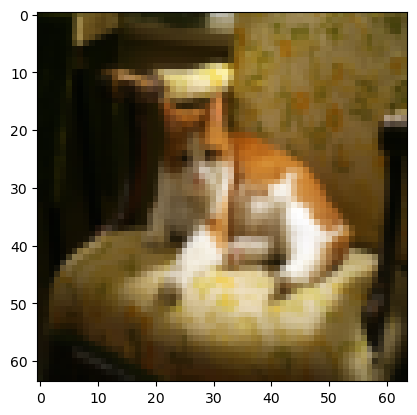

In [4]:
classes = test_dataset["list_classes"][:] # the list of classes
# Visualize sample picture
index = 7
plt.imshow(train_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print (f"y = {int(train_Y[index])}, it's a '{classes[int(train_Y[index])].decode('utf-8')}' picture.")

## Model

### Old
$ \boldsymbol{X} = \begin{bmatrix} \boldsymbol x^1 & \boldsymbol{x}^2 & \dots & \boldsymbol x^m \end{bmatrix}  $ 
$ \qquad where \qquad 
\boldsymbol x^i = \begin{bmatrix} f_1 \\ f_2 \\ f_3 \\ \vdots \\ f_d \end{bmatrix}
\qquad \qquad \qquad$ 
<br>
So &emsp; $\boldsymbol X \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,m)} $ 
&emsp; where &emsp; $\boldsymbol x^i \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,1)}$
<br>
<br>
$ \boldsymbol{Y} = \begin{bmatrix} y^1 & y^2 & \dots & y^m \end{bmatrix} 
\qquad \qquad where \qquad 
y^i$ is 0/1
<br>
So &emsp; $\boldsymbol Y \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,m)}$ 

### Now
$ \boldsymbol{X} = \begin{bmatrix} \quad \boldsymbol x^1 \quad 
\\ \quad \boldsymbol{x}^2 \quad \\ \quad \vdots \quad \\ \quad \boldsymbol x^m \quad \end{bmatrix} $ 
$ \qquad where \qquad 
\boldsymbol x^i = \begin{bmatrix} f_1 & f_2 & f_3 & \dots \quad f_d \end{bmatrix}
\qquad \qquad \qquad$ 
<br>
<br>
So &emsp; $\boldsymbol X \rightarrow \color{purple}{\ shape: \ }\color{blue}{(m,d)} $ 
&emsp; where &emsp; $\boldsymbol x^i \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,d)}$
<br>
<br>
$ \boldsymbol{Y} = \begin{bmatrix} y^1 \\ y^2 \\ \vdots \\ y^m \end{bmatrix} 
\qquad \qquad where \qquad 
y^i$ is 0/1
<br>
<br>
So &emsp; $\boldsymbol Y \rightarrow \color{purple}{\ shape: \ }\color{blue}{(m,1)}$ 

$ \boldsymbol \omega = \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_d \end{bmatrix},\qquad b $
<br>
$ \boldsymbol \omega \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,1)}$
$,\qquad \qquad \qquad b \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,)}$ 

build-in dense(X)
<br>
$ \boldsymbol{z/linear/dense} = \boldsymbol{X \omega}+b 
\qquad \qquad
\color{purple}{ \ shape: \ } \color{blue}{(m,1)=(m,d)\times(d,1)} $
<br>
$ \boldsymbol z = \begin{bmatrix} z^1 \\ z^2 \\ \vdots \\ z^m \end{bmatrix} $

In [5]:
def logistic_regression(train_X, train_Y, test_X, test_Y, printout = False,
                         learning_rate=0.005, num_epochs=2000, show_epoch=100):
    ## Create the model
    model = k.models.Sequential()
    model.add( k.layers.Dense(units=1, activation='sigmoid', input_shape=(train_X.shape[-1],),
                              kernel_initializer=k.initializers.Zeros(), bias_initializer="zeros") )
    if printout: model.summary()

    ## Compile the model
    model.compile(
        optimizer=k.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[k.metrics.BinaryAccuracy()],
    )

    class print_on_end(k.callbacks.Callback):
        def __init__(self, show_epoch=10):
            self.show_epoch = show_epoch
        def on_epoch_end(self, epoch, logs=None):
            if epoch % self.show_epoch == 0 or epoch==self.params['epochs']-1:
                print(f"{epoch+1}/{self.params['epochs']}    loss: {logs['loss']},    binary_accuracy: {logs['binary_accuracy']*100}%")
    if printout:
        callbacks=[print_on_end(show_epoch=show_epoch)]
    else:
        callbacks=[]

    ## Train the model
    hist = model.fit(train_X, train_Y, epochs=num_epochs, shuffle=False, batch_size=train_X.shape[0],
                     verbose=0,callbacks=callbacks)

    ## Evaluate the model on the test data
    if printout:
        print("\nEvaluating the model on the test data:")
        model.evaluate(test_X, test_Y, batch_size=test_X.shape[0])
    
    return hist

In [6]:
neuron_model = logistic_regression(train_X, train_Y, test_X, test_Y, printout = True, 
                                    num_epochs=2000, learning_rate=0.005, show_epoch=100)
test_Y_pred = neuron_model.model.predict(test_X, batch_size=test_X.shape[0], verbose=0)
test_Y_pred_out = tf.cast(test_Y_pred > 0.5, "float32")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 1)                 12289     
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
1/2000    loss: 0.6931471824645996,    binary_accuracy: 65.55023789405823%
101/2000    loss: 0.5845083594322205,    binary_accuracy: 67.9425835609436%
201/2000    loss: 0.46694907546043396,    binary_accuracy: 83.25358629226685%
301/2000    loss: 0.3760068714618683,    binary_accuracy: 88.51674795150757%
401/2000    loss: 0.3314632773399353,    binary_accuracy: 91.38755798339844%
501/2000    loss: 0.30327308177948,    binary_accuracy: 92.34449863433838%
601/2000    loss: 0.2798795700073242,    binary_accuracy: 93.77990365028381%
701/2000    loss: 0.26004213094711304,    binary_accuracy: 95.21530866622925%
801/2000    loss: 0.24294067919254303,    binary_accuracy: 95.69377899169922%
901/2000    loss: 0.22800421714782715,   

**Comment**: Training accuracy is close to 100%. This is a good sanity check: Test accuracy is 70%. The model is clearly overfitting the training data. It can be reduced by regularization technique and using more layers neural network to capture nonlinear complexity better.

## Plot results

y = 1,  but y_pred = 1 so predicted that it is a 'cat' picture.


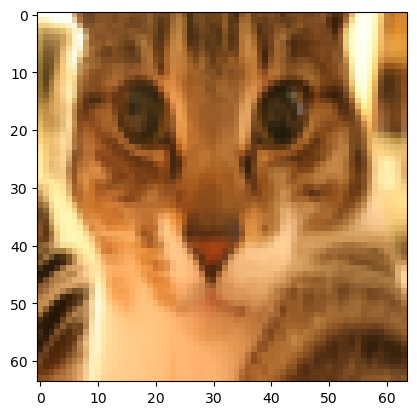

In [7]:
# Example of a picture that is rightly classified.
index = 3
plt.imshow(test_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print(f"y = {int(test_Y[index])},  but y_pred = {int(test_Y_pred_out[index])} so predicted that it is a '{classes[int(test_Y_pred_out[index])].decode('utf-8')}' picture.")

y = 0, but y_pred = 1 so predicted that it is a 'cat' picture.


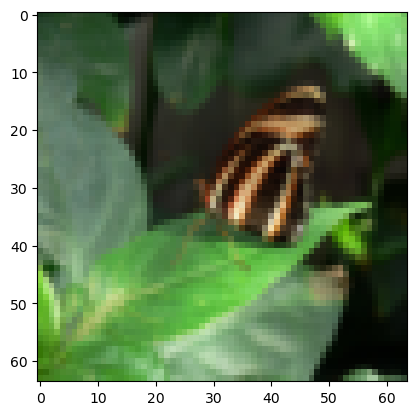

In [8]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print(f"y = {int(test_Y[index])}, but y_pred = {int(test_Y_pred_out[index])} so predicted that it is a '{classes[int(test_Y_pred_out[index])].decode('utf-8')}' picture.")

Let's also plot the cost function and the gradients.

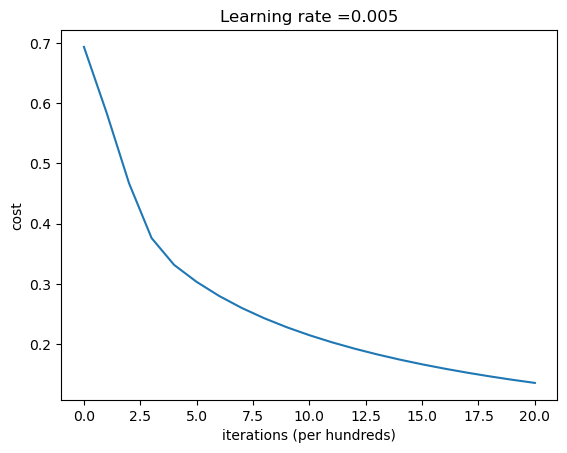

In [9]:

# Plot learning curve (with costs)
costs = neuron_model.history['loss'][0::100]
costs.append(neuron_model.history['loss'][-1])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.005))
plt.show()

**Interpretation**:
The cost decreasing shows that the parameters are being learned. However, could train the model even more on the training set. Increasing the number of iterations/epochs result in the training accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## Choice of learning rate

**Reminder**:
In order for Gradient Descent to work, must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly change the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of `learning rates`. Run the cell below. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



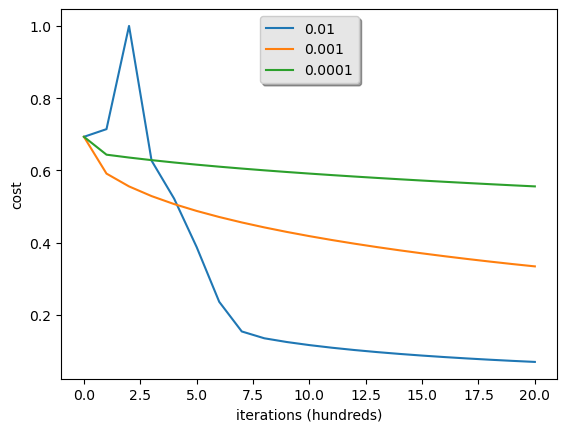

In [10]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=lr, printout=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    costs = models[str(lr)].history['loss'][0::100]
    costs.append(models[str(lr)].history['loss'][-1])
    plt.plot(costs, label=str(lr))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If model overfits, use other techniques to reduce overfitting.


## Test with your own image ##

Use your own image and see the output of your model. To do that:<br>
1. Add image to this Jupyter Notebook's directory, in the "img" folder.<br>
2. Change your image's name in the following code<br>
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!<br>

y_pred = 0, neuron algorithm predicts a 'non-cat' picture.


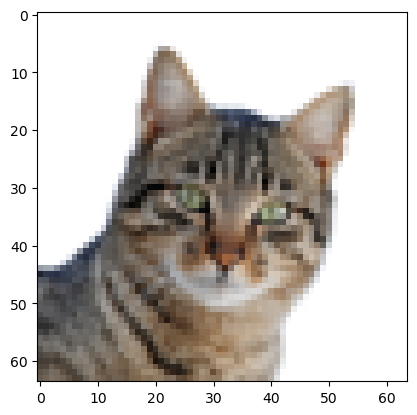

In [11]:
# change this to the name of your image file
my_image = "img/my_image_1.jpg"   

num_px = 64
# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3))   # np.ndarray shape(1, 12288)
image = tf.convert_to_tensor(image, dtype=tf.float32)

w=neuron_model.model.weights[0]; b=neuron_model.model.weights[1]
z = tf.matmul(image, w) + b    # shape(1,1) --> (1,d)X(d,1); EagerTensor float32
Y_pred = tf.sigmoid(z)                              
my_image_pred = tf.cast(Y_pred > 0.5, "float32")    

print(f"y_pred = {int(my_image_pred)}, neuron algorithm predicts a '{classes[int(my_image_pred)].decode('utf-8')}' picture.")

y_pred = 1, neuron algorithm predicts a 'cat' picture.


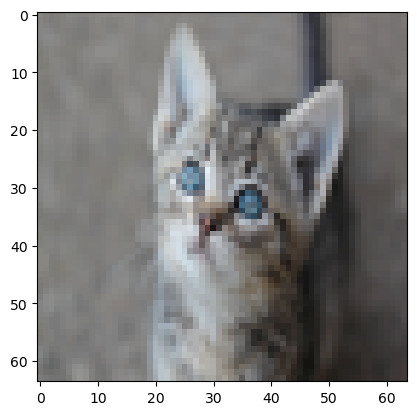

In [12]:
# change this to the name of your image file
my_image = "img/my_image_2.jpg"   

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3))    # np.ndarray shape(1, 12288)
image = tf.convert_to_tensor(image, dtype=tf.float32)

w=neuron_model.model.weights[0]; b=neuron_model.model.weights[1]
z = tf.matmul(image, w) + b    # shape(1,1) --> (1,d)X(d,1); EagerTensor float32
Y_pred = tf.sigmoid(z)                              
my_image_pred = tf.cast(Y_pred > 0.5, "float32")    

print(f"y_pred = {int(my_image_pred)}, neuron algorithm predicts a '{classes[int(my_image_pred)].decode('utf-8')}' picture.")